<h1><center>CMPE 462 - Project 1<br>Binary Classification with Logistic Regression<br>Due: April 23, 2020, 23:59</center></h1>

* **Student ID1: 2014400066**
* **Student ID2: 2014400117**
* **Student ID3: 2014400042**

# Overview

In this project, logistic regression is implemented from scratch. We are provided
a subset of the famous handwritten digit dataset called MNIST. In the subset, there are images of digit 1 and 5. Therefore, we will be solving a binary classification problem. The project includes feature extraction, model training, and evaluation steps.

Overall notebook structure is below:
* [Task 1: Feature Extraction](#feature_extraction)
    * [Data Set Visualization](#dataset_visualization)
    * [Feature Extraction Functions](#feature_extraction_functions)
    * [Representation Calculations](#representation_calculations)
* [Task 2: Logistic Regression](#logistic_regression)
    * [Sanity Checks](#logistic_regression_sanity_checks)
    * [Checking Different Learning Rates](#using_different_lr)
    * [Cross Validation](#cross_validation)
* [Task 3: Evaluation](#evaluation)
    * [Boundry Visualization](#boundry_visualization)
    * [Capacity Checks](#capacity_checks)

## Imports

In [8]:
import numpy as np
from PIL import Image, ImageFilter
import os
from matplotlib import pyplot as plt
import scipy.ndimage

<a id='feature_extraction'></a>
## Task 1: Feature Extraction

In [183]:
"""
The data is loaded into numpy arrays.
Shuffled one time to remove any bias if exists, 
for example they might have an underlying ordering.
"""

train_d = np.load('data/train_data.npy')
train_label = np.load('data/train_labels.npy')
test_d = np.load('data/test_data.npy')
test_label = np.load('data/test_labels.npy')

p = np.random.permutation(len(train_d))
train_d, train_label = train_d[p], train_label[p]

p = np.random.permutation(len(test_d))
test_d, test_label = test_d[p], test_label[p]

In [184]:
def show_example_images():
    """
    Shows 2 examples from 2 classes.
    This function is used for once to give insight about the dataset.
    Selects the first element of train set and test set to show. 
    Because the data is shuffled, each time this notebook runs, 
    different image will be shown.
    """
    
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    one_image = test_d[test_label == 1][0]
    plt.imshow(one_image.reshape(16,16), cmap='gray')
    fig.add_subplot(1,2,2)
    five_image = test_d[test_label == -1][0]
    plt.imshow(five_image.reshape(16,16), cmap='gray')
    plt.show(block=True)

def plot_features(train_data_rep, test_data_rep, draw_line=False, model=None):
    """
    Plots features and classes at the same time
    It creates a figure with two subfigures
    One is for training set, and the other is for test set.
    If draw_line functionality is True, model also need to be given.
    The function will draw the boundry line that model predicts.
    """
    
    if draw_line:
        assert model is not None, "Model need to be given to draw a line"

    # Seperate two classes to scatter on a plot with different labels
    one_images_train = train_data_rep[train_label == 1]
    five_images_train = train_data_rep[train_label == -1]
    one_images_test = test_data_rep[test_label == 1]
    five_images_test = test_data_rep[test_label == -1]
    
    # Create figure
    fig = plt.figure(figsize=(16, 8))

    # Create a subfigure for train set
    ax1 = fig.add_subplot(1,2,1)
    ax1.scatter(one_images_train[:,1], one_images_train[:,2], s=25, c='b', marker="o", label='ones')
    ax1.scatter(five_images_train[:,1], five_images_train[:,2], s=25, c='r', marker="x", label='fives')
    
    # Draw line for train set
    if draw_line:
        ax = plt.gca()
        x_vals = np.array(ax.get_xlim()).reshape(-1,1)
        y_vals = - ( x_vals * model[:,1] + model[:,0]) / model[:,2]
        plt.plot(x_vals, y_vals)

    # Create a subfigure for test set
    ax2 = fig.add_subplot(1,2,2)
    ax2.scatter(one_images_test[:,1], one_images_test[:,2], s=25, c='b', marker="o", label='ones')
    ax2.scatter(five_images_test[:,1], five_images_test[:,2], s=25, c='r', marker="x", label='fives')
    
    # Draw line for test set
    if draw_line:
        ax = plt.gca()
        x_vals = np.array(ax.get_xlim()).reshape(-1,1)
        y_vals = - ( x_vals * model[:,1] + model[:,0]) / model[:,2]
        plt.plot(x_vals, y_vals)
        
    # Set labels of both subfigures
    ax1.set_xlabel("First Feature")
    ax1.set_ylabel("Second Feature")
    ax2.set_xlabel("First Feature")
    ax2.set_ylabel("Second Feature")
    
    # Set legends for both subfugures
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')

    # Show the image
    plt.show()
    
    

<a id='dataset_visualization'></a>
#### Dataset Visualization

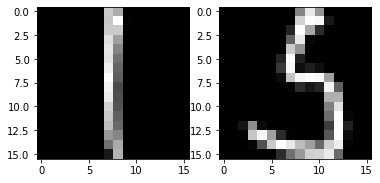

In [185]:
show_example_images()

<a id='feature_extraction_functions'></a>
#### Feature extraction functions

In [186]:
def extract_avg_intensity_feature(data):
    """
    Caculates average intensity function 
    which is simply the mean values of pixels
    """
    return np.mean(data, axis=1)

def extract_avg_cropped_intensity_feature(data):
    """
    Similar to the average intensity feature,
    calculates mean values of the pixels, 
    however uses only middle portion of the image 
    (indices between 6 and 9 for 16x16 image).
    """
    return np.mean(data[:,6:9], axis=1)

def extract_symmetry_feature(data):
    """
    Calculates the symmetry feature.
    Calculates the flipped version of the 
    image with respect to y axis and calculates l_2 loss 
    between the original image and its flipped version
    """
    return -np.mean((np.absolute(data - np.fliplr(data))), axis=1)
    #return -np.linalg.norm(data - np.fliplr(data), ord=2, axis=1)

def extract_average_row_lenght(data):
    """
    For each raw of the image, finds indices of not black pixels.
    Calculates the difference between the highest and lowest indice.
    """
    all_scores = np.zeros((data.shape[0], 1))
    for idx, one_image in enumerate(data):
        im = one_image.reshape(16,16) * 255
        score = 0
        for row in im:
            inds = np.where(row != -255.)
            if np.where(row != -255.)[0].shape[0] == 0:
                continue
            score += inds[0][-1] - inds[0][0]
        all_scores[idx] = score / 16
    return all_scores

def extract_centrality_feature(data):
    """
    For each raw of the image, finds indices of not black pixels.
    Finds how close the farthest non-white pixel to the center.
    To achive this, calculate the following:
    (indice number of smallest indice nubmer) + (16 - indice number of higest indice number)
    For five images it is expected the result is higher
    """
    all_scores = np.zeros((data.shape[0], 1))
    for idx, one_image in enumerate(data):
        im = one_image.reshape(16,16) * 255
        score = 0
        for row in im:
            inds = np.where(row != -255.)
            if np.where(row != -255.)[0].shape[0] == 0:
                continue
            score += inds[0][0] + 16 - inds[0][-1]
        all_scores[idx] = score / 16
    return all_scores

def extract_changes_in_columns_feature(data):
    """
    Traverse the columns of each images and calculates the number of color 
    changes for each column. To find color changes, looks to neigbour pixels 
    of each pixels, if the numerical value of current pixel is higher or lower than 
    the both neighbours, counts it as color change. For five images we expect this
    number to be high.
    """
    all_scores = np.zeros((data.shape[0], 1))
    for idx, one_image in enumerate(data):
        one_image = one_image.reshape(16,16)
        sums = 0
        for a in one_image.T:
            k = np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True]
            sums += np.sum(k)
        all_scores[idx] = sums
    return all_scores
        
def extract_number_of_white_feature(data):
    """
    Calculates the number of white pixels
    """
    return np.sum((data != -1.), axis=1)

def create_intercept_terms(data):
    """
    Creates ones vector and concatenates it to the feature vectors.
    This ones vector is necessary for bias(intercept) term. Add this 
    feature as the first feature to the all configurations of your feature 
    selection vectors.
    """
    return np.ones((data.shape[0],1))

def extract_features(data, ext_fn):
    """
    Passes `data` to given feature-extractor functions given as
    `ext_fn` and returns a new matrix with each feature in one column
    """
    return np.column_stack(tuple(map(lambda fn: fn(data), ext_fn)))

def calculate_mean_and_std(data):
    """
    Calcualtes the mean and std of given data. The data contains all images
    in its rows and features in its columns. Calculation of mean and std is done
    for each feature seperately.
    """
    mu_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)
    return mu_vals, std_vals

def normalize_features(data, mu_vals, std_vals):
    """
    Normalizes the features matrix with given mean and standart deviation values.
    """
    return (data - mu_vals) / (std_vals + 1e-7)


<a id='representation_calculations'></a>
### Calculate Representation 1

In [198]:
# Features to use in representation 1
features_to_use_1 = [
    create_intercept_terms, # Don't delete this feature !!!!
    extract_symmetry_feature,
    extract_avg_intensity_feature,
    #extract_number_of_white_feature,
    #extract_centrality_feature,
    #extract_changes_in_columns_feature,
    #extract_avg_cropped_intensity_feature,
    #extract_average_row_lenght,
]

# Check the first intercept feature
assert features_to_use_1[0] == create_intercept_terms, "First feature should be the intercept terms so that the model works fine"

# Extract feature for train and test set wrt feature vector
test_data_rep1 = extract_features(test_d, features_to_use_1)
train_data_rep1 = extract_features(train_d, features_to_use_1)

# Calculate the mean and standart deviation of train set
feature_mean_rep1, feature_std_rep1 = calculate_mean_and_std(train_data_rep1)

# Normalize both train and test set using the statistics of train set
train_data_rep1 = normalize_features(train_data_rep1, feature_mean_rep1, feature_std_rep1)
test_data_rep1 = normalize_features(test_data_rep1, feature_mean_rep1, feature_std_rep1)

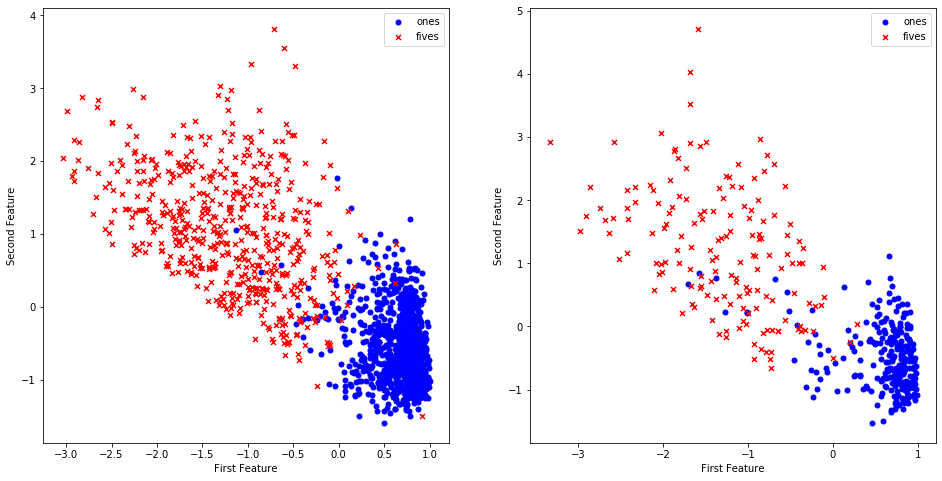

In [199]:
# Plot data distribution of train and test set
plot_features(train_data_rep1, test_data_rep1)

### Calculate Representation 2

In [189]:
# Features to use in representation 2
features_to_use_2 = [
    create_intercept_terms, # Don't delete this feature !!!!
    #extract_symmetry_feature,
    #extract_avg_intensity_feature,
    #extract_number_of_white_feature,
    extract_centrality_feature,
    extract_changes_in_columns_feature,
    #extract_avg_cropped_intensity_feature,
    #extract_average_row_lenght,
]

# Check the first intercept feature
assert features_to_use_2[0] == create_intercept_terms, "First feature should be the intercept terms so that the model works fine"

# Extract feature for train and test set wrt feature vector
test_data_rep2 = extract_features(test_d, features_to_use_2)
train_data_rep2 = extract_features(train_d, features_to_use_2)

# Calculate the mean and standart deviation of train set
feature_mean_rep2, feature_std_rep2 = calculate_mean_and_std(train_data_rep2)

# Normalize both train and test set using the statistics of train set
train_data_rep2 = normalize_features(train_data_rep2, feature_mean_rep2, feature_std_rep2)
test_data_rep2 = normalize_features(test_data_rep2, feature_mean_rep2, feature_std_rep2)

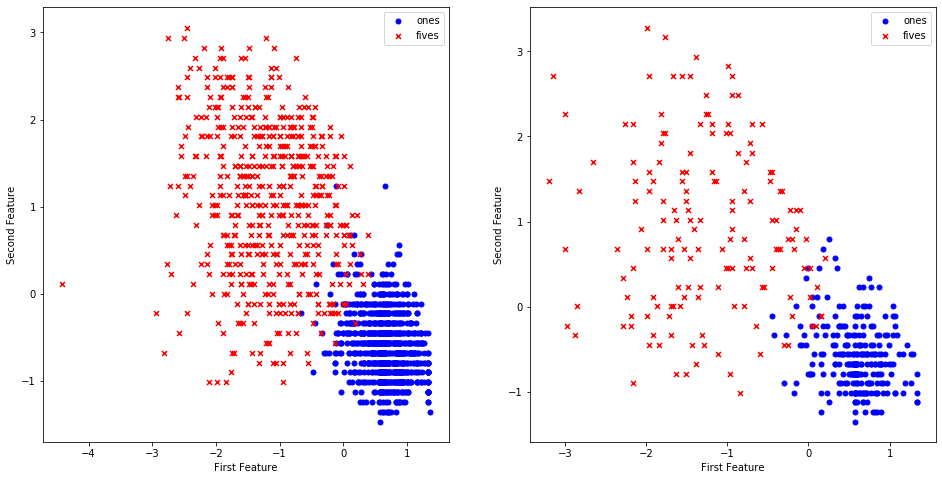

In [190]:
# Plot data distribution of train and test set
plot_features(train_data_rep2, test_data_rep2)

### Calculate Representation 3

In [191]:
# Features to use in representation 3
features_to_use_3 = [
    create_intercept_terms, # Don't delete this feature !!!!
    extract_symmetry_feature,
    extract_avg_intensity_feature,
    extract_number_of_white_feature,
    extract_centrality_feature,
    extract_changes_in_columns_feature,
    extract_avg_cropped_intensity_feature,
    extract_average_row_lenght,
]

# Check the first intercept feature
assert features_to_use_3[0] == create_intercept_terms, "First feature should be the intercept terms so that the model works fine"

# Extract feature for train and test set wrt feature vector
test_data_rep3 = extract_features(test_d, features_to_use_3)
train_data_rep3 = extract_features(train_d, features_to_use_3)

# Calculate the mean and standart deviation of train set
feature_mean_rep3, feature_std_rep3 = calculate_mean_and_std(train_data_rep3)

# Normalize both train and test set using the statistics of train set
train_data_rep3 = normalize_features(train_data_rep3, feature_mean_rep3, feature_std_rep3)
test_data_rep3 = normalize_features(test_data_rep3, feature_mean_rep3, feature_std_rep3)

<a id='logistic_regression'></a>
## Task 2: Logistic Regression

In [192]:
class HardToMinimizeLogisticRegression():
    """
    Logistic regression classifier implementation.
    This implementation uses loss function shown in the 
    lecture and said that it is hard to minimize.
    It still converges, however, for the following tasks 
    done in this notebook, other logistic regression implementaiton is used.
    Please refer to that implementation.
    """
    def __init__(self, number_of_features):
        self.number_of_features = number_of_features # ex = 2 + 1
        self.init_model()

    def init_model(self):
        self.model = 0.001 * np.random.normal(0, 0.1, self.number_of_features).reshape(1,-1)
        self.prev_loss = np.inf
        self.print_index = 0

    def sigmoid(self, data):
        return 1 / (1 + np.exp(-data))

    def loss_and_grad(self, train_data, train_label, reg_term):
        a = self.sigmoid(np.matmul(train_data, self.model.T))
        loss = (np.mean(- train_label * np.log(a) - (1 - train_label) * np.log(1-a))) + \
               (reg_term / 2.0) * np.sum(self.model ** 2) / self.model.shape[0]
        grad = np.mean((a - train_label) * train_data, axis=0) + \
               (reg_term * np.sum(self.model) / self.model.shape[0])
        return loss, grad

    def update_model(self, grad, lr):
        self.model = self.model - grad * lr

    def predict(self, data, label):
        prob = self.sigmoid(np.matmul(data, self.model.T))
        prob = prob.reshape(-1,)
        prob[prob <= 0.5] = 0
        prob[prob > 0.5] = 1
        accuracy = np.sum(prob == label, dtype=int) / label.shape[0]
        return accuracy

    def fit(self, train_data, train_label, test_data=None, test_label=None, lr=1e-2, verbose=True, reg_term=0):
        train_label = train_label.reshape(-1,1)
        train_loss_vals = []
        test_loss_vals = []
        while True:
            self.print_index += 1
            loss, grad = self.loss_and_grad(train_data, train_label, reg_term)    
            self.update_model(grad, lr)
            if self.prev_loss - loss < 1e-6:
                break
            self.prev_loss = loss
            train_loss_vals.append(loss)
            if verbose and self.print_index % 2000 == 0:
                print(loss)
            
            if not test_data is None:
                loss_test, _ = self.loss_and_grad(test_data, test_label.reshape(-1,1), reg_term)
                test_loss_vals.append(loss_test)
                
        loss_to_return = {'train_loss': train_loss_vals, 'test_loss': test_loss_vals}
        return self.model, loss_to_return


In [193]:
class LogisticRegression():
    """
    Logistic regression classifier implementation.
    This class implements the logistic regression for binary classification.
    Uses logistic loss function and full batch gradient descent to 
    optimize its parameters. 
    """
    def __init__(self, number_of_features):
        """
        Initialize the logistic regression classifier. In the initialization, 
        number of feature should be given so that the number of parameters is setted
        In the features intercept term should be included as a first feature
        """
        self.number_of_features = number_of_features # ex = 2 + 1
        self.init_model()

    def init_model(self):
        """
        Initialize the logistic regression model. According to the number of parameters
        the model draws values from normal distribution with 0 mean and 0.1 variance, and
        multiplies all values with 0.001 to have small starting points. Zero initialization
        is not used because of possible problems that may occur with zero intialization.
        prev_loss variable is also initialized as infinite, it will be optimized during training.
        Final value of the loss can be obtained using this variable after training.
        """
        # Variable that hold the parameters
        self.model = np.random.normal(0, 0.5, self.number_of_features).reshape(1,-1)
        self.prev_loss = np.inf
        self.print_index = 0

    def sigmoid(self, data):
        """
        Sigmoid implementation.
        Sigmoid has a simple implementation, however, according to machine leatning 
        community it is not stable. So we included stable version of it.
        """
        return np.where(data >= 0, 1 / (1 + np.exp(-data)), np.exp(data) / (1 + np.exp(data)))

    def loss_and_grad(self, train_data, train_label, reg_term):
        """
        Calculates the loss value and gradient loss functions with respect to parameters.
        As a loss function, logistic loss is used. Also l_2 regularization is implemented.
        Using reg_term parameter, one can adjust the amount of regularization applied.
        """
        N = train_data.shape[0]
        wTy = np.matmul(train_data, self.model.T)
        # Loss calculation
        loss = (1.0 / N) * np.sum(np.log(1 + np.exp(-train_label * wTy))) + \
               (reg_term / 2.0) * np.sum(self.model ** 2) / self.model.shape[0]
        # Gradient calculation
        grad = (1.0 / N) * np.sum((-train_label * train_data * np.exp(-train_label * wTy)) / (1 + np.exp(-train_label * wTy)), axis=0) + \
               (reg_term * np.sum(self.model) / self.model.shape[0])
        return loss, grad

    def update_model(self, grad, lr):
        """
        Updates model parameters using the given gradients and learning rate
        """
        self.model = self.model - grad * lr

    def predict(self, data, label):
        """
        Makes a prediction using the current model parameters.
        This method should be called after calling fit function. Otherwise 
        random predictions will be given
        """
        prob = self.sigmoid(np.matmul(data, self.model.T))
        prob = prob.reshape(-1,)
        prob[prob <= 0.5] = -1
        prob[prob > 0.5] = 1
        accuracy = np.sum(prob == label, dtype=int) / label.shape[0]
        return accuracy

    def fit(self, train_data, train_label, test_data=None, test_label=None, lr=1e-2, verbose=True, reg_term=0, stop_thresh=1e-5):
        """
        Training function of logistic regression classifier.
        Takes the training data with train label and runs the logistic regression
        algorithm until the loss change becomes smaller thatn stoping threshold.
        In each iteration loss and gradient values are calculated using the 
        function of this class. Using the resultant gradients, the model parameters
        are updated.
        
        Optionally, the function can take test data and label. These are not used 
        in training at any condition. They are used to calculate loss values during each 
        iteration of training, in order to compare the loss of test data with the loss of
        training data. Overfitting can be detected using this feature.
        
        Parameters
        ----------
        train_data : numpy.ndarray
            Training data with shape (number of images, number of features)
        train_label : numpy.ndarray
            Training labels with shape (number of images,)
        test_data : numpy.ndarray, default=None
            Test data with shape (number of images, number of features)
            This data is used to calculate loss of test data during traing.
            It is not used to update any parameter.
        train_label : numpy.ndarray, default=None
            Test labels with shape (number of images,)
        lr : float, default=1e-2
            Learning rate that is used in training.
            Higher learning rates will result in higer convergence, however,
            if it is too high, the model may not be able to learn
        verbose: bool, default=True
            Specifies whether the loss values should be printed to the console 
            or not
        reg_term: float, default=0
            Specifies the amount of regularization that will be applied to the 
            loss function. If it is too high, it may prevent the model to learn
            anything
        stop_thresh: float, default=1e-6
            Specifies at which point the training should stop. If the loss change
            is smaller that the stop threshold, the training will stop
        """
        train_label = train_label.reshape(-1,1)
        train_loss_vals = []
        test_loss_vals = []
        while True:
            self.print_index += 1
            loss, grad = self.loss_and_grad(train_data, train_label, reg_term)    
            self.update_model(grad, lr)
            if np.absolute(self.prev_loss - loss < stop_thresh):
                break
            self.prev_loss = loss
            train_loss_vals.append(loss)
            if verbose and self.print_index % 2000 == 0:
                print(loss)
            
            if not test_data is None:
                loss_test, _ = self.loss_and_grad(test_data, test_label.reshape(-1,1), reg_term)
                test_loss_vals.append(loss_test)
                
        loss_to_return = {'train_loss': train_loss_vals, 'test_loss': test_loss_vals}
        return self.model, loss_to_return


<a id='logistic_regression_sanity_checks'></a>
### Run logistic regression without regularization for Representation 1

In [194]:
logistic_regression = LogisticRegression(number_of_features=len(features_to_use_1))
trained_model_rep1, loss_vals_rep1 = logistic_regression.fit(train_data_rep1, train_label, test_data_rep1, test_label, verbose=False, lr=1e-2, reg_term=0.0)

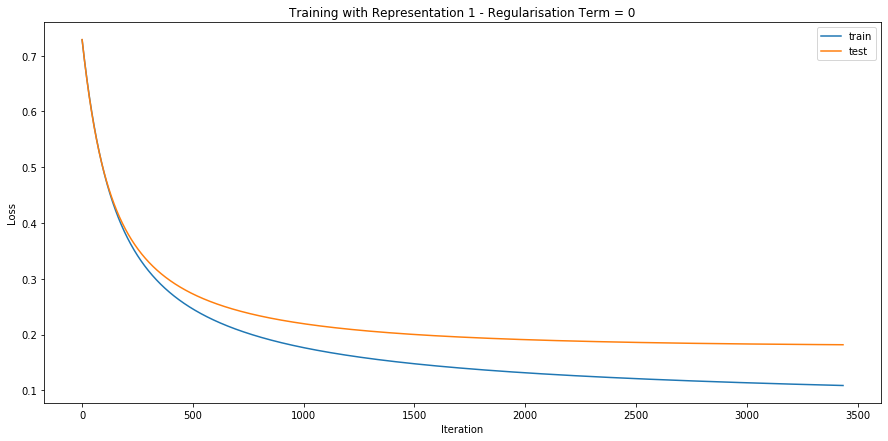

In [195]:
plt.figure(figsize=(15,7))
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training with Representation 1 - Regularisation Term = 0")
plt.plot(loss_vals_rep1['train_loss'], label='train')
plt.plot(loss_vals_rep1['test_loss'], label='test')
plt.legend(loc='upper right')
plt.show()

### Run logistic regression with regularization for Representation 1

In [196]:
logistic_regression = LogisticRegression(number_of_features=len(features_to_use_1))
trained_model_rep1, loss_vals_rep1 = logistic_regression.fit(train_data_rep1, train_label, test_data_rep1, test_label, verbose=False, lr=1e-3, reg_term=0.1)

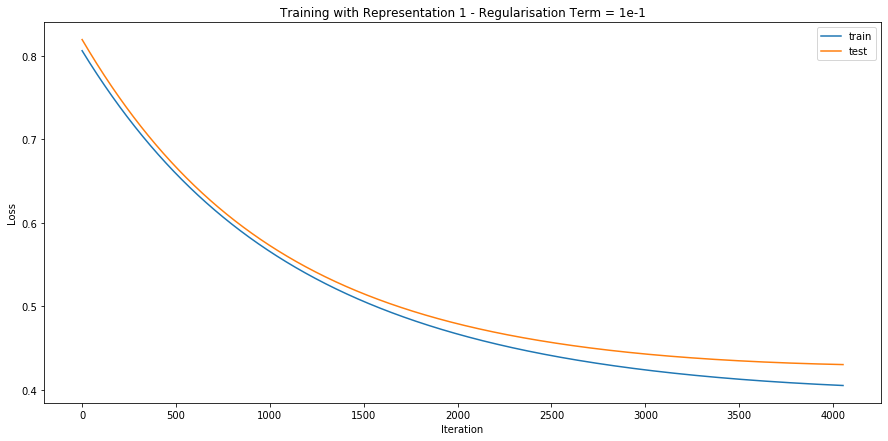

In [197]:
plt.figure(figsize=(15,7))
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training with Representation 1 - Regularisation Term = 1e-1")
plt.plot(loss_vals_rep1['train_loss'], label='train')
plt.plot(loss_vals_rep1['test_loss'], label='test')
plt.legend(loc='upper right')
plt.show()

### Run logistic regression without regularization for Representation 2

In [19]:
logistic_regression = LogisticRegression(number_of_features=len(features_to_use_2))
trained_model_rep2, loss_vals_rep2 = logistic_regression.fit(train_data_rep2, train_label, test_data_rep2, test_label, verbose=False, lr=1e-3, reg_term=0.0)

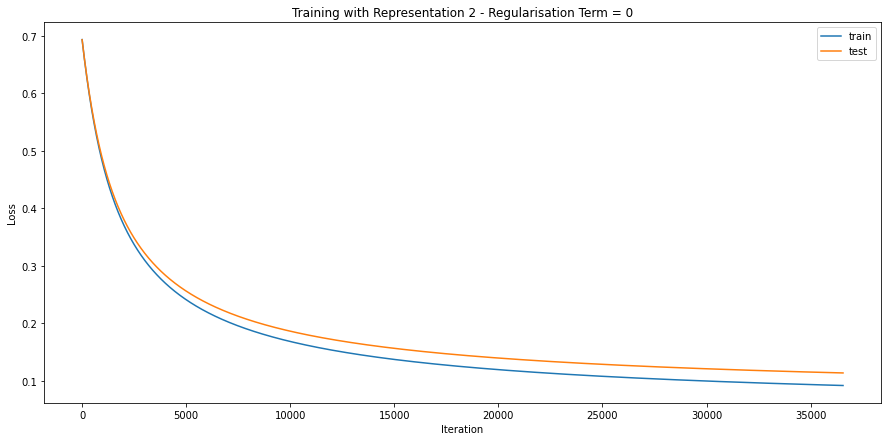

In [20]:
plt.figure(figsize=(15,7))
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training with Representation 2 - Regularisation Term = 0")
plt.plot(loss_vals_rep2['train_loss'], label='train')
plt.plot(loss_vals_rep2['test_loss'], label='test')
plt.legend(loc='upper right')
plt.show()

### Run logistic regression with regularization for Representation 2

In [21]:
logistic_regression = LogisticRegression(number_of_features=len(features_to_use_2))
trained_model_rep2, loss_vals_rep2 = logistic_regression.fit(train_data_rep2, train_label, test_data_rep2, test_label, verbose=False, lr=1e-3, reg_term=0.1)

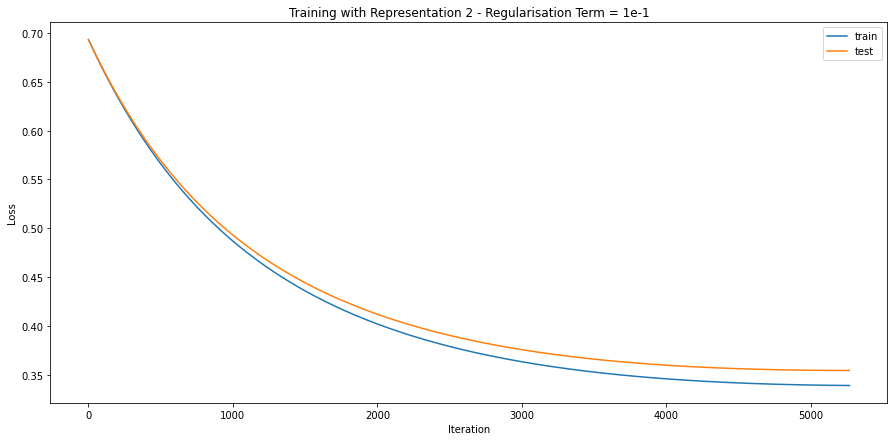

In [22]:
plt.figure(figsize=(15,7))
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training with Representation 2 - Regularisation Term = 1e-1")
plt.plot(loss_vals_rep2['train_loss'], label='train')
plt.plot(loss_vals_rep2['test_loss'], label='test')
plt.legend(loc='upper right')
plt.show()

<a id='using_different_lr'></a>
### Run the logistic regression for different learning rates using Representation 2

In [23]:
# Run for learning rate 1e-3
logistic_regression = LogisticRegression(number_of_features=len(features_to_use_2))
trained_model1, loss_vals1 = logistic_regression.fit(train_data_rep2, train_label, test_data_rep2, test_label, lr=1e-3, verbose=False, reg_term=0.1)
# Run for learning rate 5e-4
logistic_regression = LogisticRegression(number_of_features=len(features_to_use_2))
trained_model2, loss_vals2 = logistic_regression.fit(train_data_rep2, train_label, test_data_rep2, test_label, lr=5e-4, verbose=False, reg_term=0.1)
# Run for learning rate 1e-4
logistic_regression = LogisticRegression(number_of_features=len(features_to_use_2))
trained_model3, loss_vals3 = logistic_regression.fit(train_data_rep2, train_label, test_data_rep2, test_label, lr=1e-4, verbose=False, reg_term=0.1)
# Run for learning rate 5e-5
logistic_regression = LogisticRegression(number_of_features=len(features_to_use_2))
trained_model4, loss_vals4 = logistic_regression.fit(train_data_rep2, train_label, test_data_rep2, test_label, lr=5e-5, verbose=False, reg_term=0.1)
# Run for learning rate 2e-5
logistic_regression = LogisticRegression(number_of_features=len(features_to_use_2))
trained_model5, loss_vals5 = logistic_regression.fit(train_data_rep2, train_label, test_data_rep2, test_label, lr=2e-5, verbose=False, reg_term=0.1)

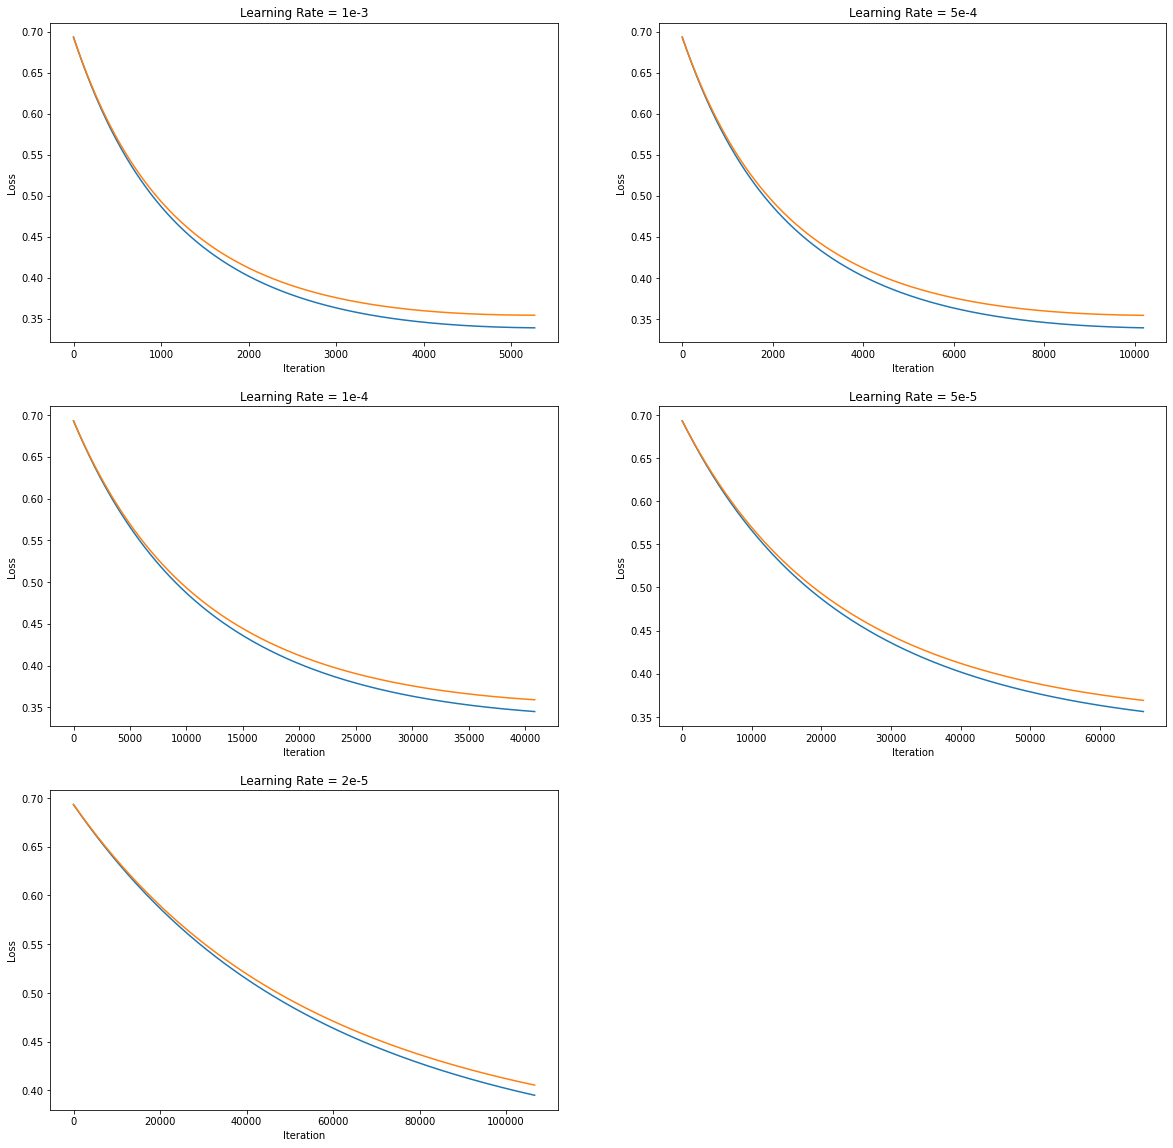

In [24]:
# Create figure
fig = plt.figure(figsize=(20,20))

# Create subfigures
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)

# Plot loss values of diffent trainings
ax1.plot(loss_vals1['train_loss'], label='train')
ax1.plot(loss_vals1['test_loss'], label='test')
ax2.plot(loss_vals2['train_loss'], label='train')
ax2.plot(loss_vals2['test_loss'], label='test')
ax3.plot(loss_vals3['train_loss'], label='train')
ax3.plot(loss_vals3['test_loss'], label='test')
ax4.plot(loss_vals4['train_loss'], label='train')
ax4.plot(loss_vals4['test_loss'], label='test')
ax5.plot(loss_vals5['train_loss'], label='train')
ax5.plot(loss_vals5['test_loss'], label='test')

# Set titles for all subplots
ax1.title.set_text('Learning Rate = 1e-3')
ax2.title.set_text('Learning Rate = 5e-4')
ax3.title.set_text('Learning Rate = 1e-4')
ax4.title.set_text('Learning Rate = 5e-5')
ax5.title.set_text('Learning Rate = 2e-5')

# Set axis labels for subplots
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Loss")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Loss")
ax5.set_xlabel("Iteration")
ax5.set_ylabel("Loss")

# Show the plot
plt.show()

<a id='cross_validation'></a>
### Cross validation

In [25]:
def cross_validation(data_, label_, n_of_features=3):
    """
    Implements 5-fold cross validation to select correct regularization term.
    As a procedure, the data is splitted into 5 subsets. For each regularization
    value, 5 classifier is trained. For each training one subset is selected as 
    validation set, and the other four are selected as training set. 
    For 5 different classifiers, 5 different prediction is taken. The
    results are colected into a dictionary and they are returned.
    """
    # Copy the original data in order to protect the original values
    train_data_ = data_.copy()
    train_label_ = label_.copy()
    
    # Split data and label into 5 fold
    partitions_data = np.array_split(train_data_, 5)
    partitions_label = np.array_split(train_label_, 5)
    configs = {}
    
    # Traverse values that will be cross-validated
    for l in [0.4, 0.3, 0.2, 0.1, 0.0]:
        all_accuracies = []
        for i in range(5):
            train_data_set, train_label_set = [], []
            test_data_set, test_label_set = [], []

            # Create validation set and training set using 5 folds
            for j in range(5):
                if i == j:
                    test_data_set.extend(partitions_data[j])
                    test_label_set.extend(partitions_label[j])
                else:
                    train_data_set.extend(partitions_data[j])
                    train_label_set.extend(partitions_label[j])

            # Convert everything into numpy array
            train_data_set, train_label_set = np.array(train_data_set), np.array(train_label_set)
            test_data_set, test_label_set = np.array(test_data_set), np.array(test_label_set)

            # Traing a classifier
            logistic_regression = LogisticRegression(number_of_features=n_of_features)
            model, loss_vals = logistic_regression.fit(train_data_set, train_label_set, lr=1e-3, verbose=False, reg_term=l)
            
            # Make a prediction and collect the result
            accuracy = logistic_regression.predict(test_data_set, test_label_set)
            all_accuracies.append(accuracy)

        configs[l] = all_accuracies
        
    return configs

<a id='cross_validation_for_all_reps'></a>
### Run cross validation for all representations

In [26]:
# Cross validation for representation 1
configs_rep1 = cross_validation(train_data_rep1, train_label)

In [27]:
# Cross validation for representation 2
configs_rep2 = cross_validation(train_data_rep2, train_label)

In [28]:
# Cross validation for representation 3
configs_rep3 = cross_validation(train_data_rep3, train_label, n_of_features=len(features_to_use_3))

### Report the cross validation results

In [29]:
print("Representation 1")
for k, v in configs_rep1.items():
    mean, std = np.mean(v), np.std(v)
    print(f"For regularization term {k}, mean accuracy is {mean}, std is {std}")
print("----------------")
print("Representation 2")
for k, v in configs_rep2.items():
    mean, std = np.mean(v), np.std(v)
    print(f"For regularization term {k}, mean accuracy is {mean}, std is {std}")
print("----------------")
print("Representation 3")
for k, v in configs_rep3.items():
    mean, std = np.mean(v), np.std(v)
    print(f"For regularization term {k}, mean accuracy is {mean}, std is {std}")

Representation 1
For regularization term 0.4, mean accuracy is 0.9538789219300401, std is 0.004762288203685589
For regularization term 0.3, mean accuracy is 0.9532378962890146, std is 0.005562344536970578
For regularization term 0.2, mean accuracy is 0.954517899565823, std is 0.005500351133297073
For regularization term 0.1, mean accuracy is 0.9564409764888998, std is 0.004768569883811265
For regularization term 0.0, mean accuracy is 0.9564389284836569, std is 0.0052009696976719815
----------------
Representation 2
For regularization term 0.4, mean accuracy is 0.9775845826165315, std is 0.006693904431484767
For regularization term 0.3, mean accuracy is 0.9782256082575571, std is 0.006181219790716158
For regularization term 0.2, mean accuracy is 0.9782256082575571, std is 0.006181219790716158
For regularization term 0.1, mean accuracy is 0.9788666338985827, std is 0.006871777558799452
For regularization term 0.0, mean accuracy is 0.9814286884574426, std is 0.006816703539498347
---------

<a id='evaluation'></a>
## Task 3: Evaluation

#### Run the classifier for Representation 1 for both regularized and non-regularized version and report the accuracy

In [177]:
logistic_regression = LogisticRegression(number_of_features=3)
trained_model_rep1_no_reg, loss_vals_final = logistic_regression.fit(train_data_rep1, train_label, test_data_rep1, test_label, verbose=False, lr=0.2, reg_term=0.0, stop_thresh=1e-5)

In [180]:
training_accuracy = logistic_regression.predict(train_data_rep1, train_label)
test_accuracy = logistic_regression.predict(test_data_rep1, test_label)
print("Result of training representation 1 with 0 regularization")
print(f"Training accuracy is {training_accuracy}, Test accuracy is {test_accuracy}")

Result of training representation 1 with 0 regularization
Training accuracy is 0.9807815502882767, Test accuracy is 0.9622641509433962


In [158]:
logistic_regression = LogisticRegression(number_of_features=3)
trained_model_rep1_with_reg, loss_vals_final = logistic_regression.fit(train_data_rep1, train_label, test_data_rep1, test_label, verbose=False, lr=1e-2, reg_term=0.00001)

In [159]:
training_accuracy = logistic_regression.predict(train_data_rep1, train_label)
test_accuracy = logistic_regression.predict(test_data_rep1, test_label)
print("Result of training representation 1 with 0.1 regularization")
print(f"Training accuracy is {training_accuracy}, Test accuracy is {test_accuracy}")

Result of training representation 1 with 0.1 regularization
Training accuracy is 0.9532351057014734, Test accuracy is 0.9457547169811321


#### Run the classifier for Representation 2 for both regularized and non-regularized version and report the accuracy

In [136]:
logistic_regression = LogisticRegression(number_of_features=3)
trained_model_rep2_no_reg, loss_vals_final = logistic_regression.fit(train_data_rep2, train_label, test_data_rep2, test_label, verbose=False, lr=1e-2, reg_term=0.0)

NameError: name 'train_data_rep2' is not defined

In [137]:
training_accuracy = logistic_regression.predict(train_data_rep2, train_label)
test_accuracy = logistic_regression.predict(test_data_rep2, test_label)
print("Result of training representation 2 with 0 regularization")
print(f"Training accuracy is {training_accuracy}, Test accuracy is {test_accuracy}")

NameError: name 'train_data_rep2' is not defined

In [36]:
logistic_regression = LogisticRegression(number_of_features=3)
trained_model_rep2_with_reg, loss_vals_final = logistic_regression.fit(train_data_rep2, train_label, test_data_rep2, test_label, verbose=False, lr=1e-2, reg_term=0.1)

In [37]:
training_accuracy = logistic_regression.predict(train_data_rep2, train_label)
test_accuracy = logistic_regression.predict(test_data_rep2, test_label)
print("Result of training representation 2 with 0.1 regularization")
print(f"Training accuracy is {training_accuracy}, Test accuracy is {test_accuracy}")

Result of training representation 2 with 0.1 regularization
Training accuracy is 0.9788597053171044, Test accuracy is 0.9575471698113207


#### Run the classifier for Representation 3 for both regularized and non-regularized version and report the accuracy

In [38]:
logistic_regression = LogisticRegression(number_of_features=8)
trained_model_rep3_no_reg, loss_vals_final = logistic_regression.fit(train_data_rep3, train_label, test_data_rep3, test_label, verbose=False, lr=5e-4, reg_term=0.0, stop_thresh=1e-7)

In [39]:
training_accuracy = logistic_regression.predict(train_data_rep3, train_label)
test_accuracy = logistic_regression.predict(test_data_rep3, test_label)
print("Result of training representation 3 with 0 regularization")
print(f"Training accuracy is {training_accuracy}, Test accuracy is {test_accuracy}")

Result of training representation 3 with 0 regularization
Training accuracy is 0.9903907751441384, Test accuracy is 0.9669811320754716


In [40]:
logistic_regression = LogisticRegression(number_of_features=8)
trained_model_rep3_with_reg, loss_vals_final = logistic_regression.fit(train_data_rep3, train_label, test_data_rep3, test_label, verbose=False, lr=5e-4, reg_term=0.1, stop_thresh=1e-7)

In [41]:
training_accuracy = logistic_regression.predict(train_data_rep3, train_label)
test_accuracy = logistic_regression.predict(test_data_rep3, test_label)
print("Result of training representation 3 with 0.1 regularization")
print(f"Training accuracy is {training_accuracy}, Test accuracy is {test_accuracy}")

Result of training representation 3 with 0.1 regularization
Training accuracy is 0.9891095451633568, Test accuracy is 0.9622641509433962


<a id='boundry_visualization'></a>
### Visualization of the decision boundry for classifier trained on Representation 1

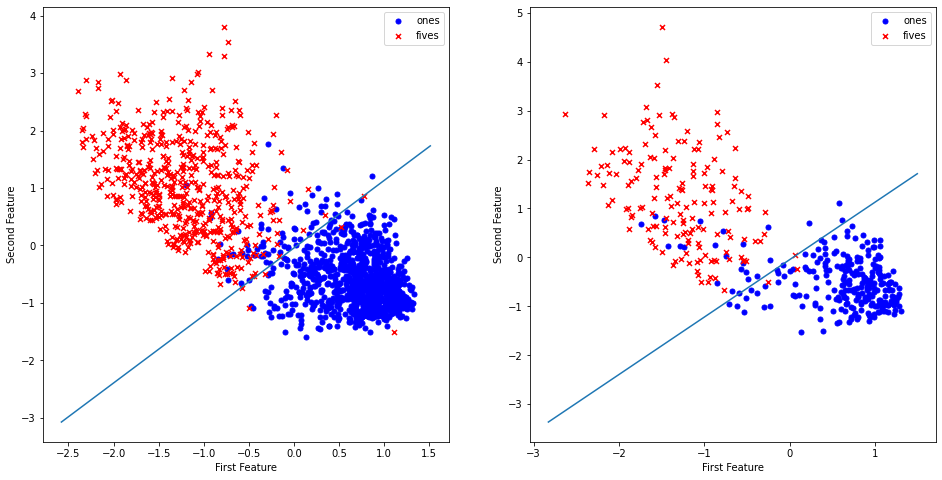

In [42]:
plot_features(train_data_rep1, test_data_rep1, draw_line=True, model=trained_model_rep1_with_reg)

<a id='capacity_checks'></a>
# Plots and tests to understand the capacity of each representation

## For feature set 1

Capacity of the feature set 1 without regularization model
Training accuracy is 0.957078795643818, Test accuracy is 0.9363207547169812
Capacity of the feature set 1 with regularization model
Training accuracy is 0.9551569506726457, Test accuracy is 0.9386792452830188


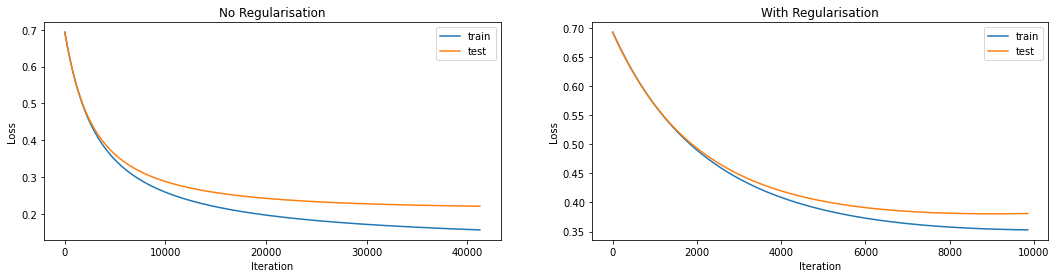

In [47]:
logistic_regression = LogisticRegression(number_of_features=len(features_to_use_1))
trained_model, loss_vals_final_no_reg = logistic_regression.fit(train_data_rep1, train_label, test_data_rep1, test_label, verbose=False, lr=5e-4, reg_term=0.0)

print("Capacity of the feature set 1 without regularization model")
training_accuracy = logistic_regression.predict(train_data_rep1, train_label)
test_accuracy = logistic_regression.predict(test_data_rep1, test_label)
print(f"Training accuracy is {training_accuracy}, Test accuracy is {test_accuracy}")

logistic_regression = LogisticRegression(number_of_features=len(features_to_use_1))
trained_model, loss_vals_final_with_reg = logistic_regression.fit(train_data_rep1, train_label, test_data_rep1, test_label, verbose=False, lr=5e-4, reg_term=0.1)

print("Capacity of the feature set 1 with regularization model")
training_accuracy = logistic_regression.predict(train_data_rep1, train_label)
test_accuracy = logistic_regression.predict(test_data_rep1, test_label)
print(f"Training accuracy is {training_accuracy}, Test accuracy is {test_accuracy}")

fig = plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(loss_vals_final_no_reg['train_loss'], label='train')
ax1.plot(loss_vals_final_no_reg['test_loss'], label='test')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.title.set_text("No Regularisation")
ax1.legend(loc='upper right')

ax2.plot(loss_vals_final_with_reg['train_loss'], label='train')
ax2.plot(loss_vals_final_with_reg['test_loss'], label='test')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss")
ax2.title.set_text("With Regularisation")
ax2.legend(loc='upper right')

plt.show()

## For feature set 2

Capacity of the feature set 2 without regularization model
Training accuracy is 0.9807815502882767, Test accuracy is 0.9575471698113207
Capacity of the feature set 2 with regularization model
Training accuracy is 0.9788597053171044, Test accuracy is 0.9575471698113207


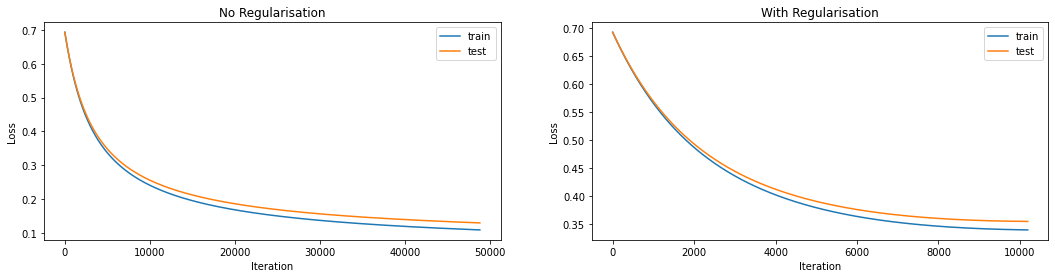

In [48]:
logistic_regression = LogisticRegression(number_of_features=len(features_to_use_2))
trained_model, loss_vals_final_no_reg = logistic_regression.fit(train_data_rep2, train_label, test_data_rep2, test_label, verbose=False, lr=5e-4, reg_term=0.0)

print("Capacity of the feature set 2 without regularization model")
training_accuracy = logistic_regression.predict(train_data_rep2, train_label)
test_accuracy = logistic_regression.predict(test_data_rep2, test_label)
print(f"Training accuracy is {training_accuracy}, Test accuracy is {test_accuracy}")

logistic_regression = LogisticRegression(number_of_features=len(features_to_use_2))
trained_model, loss_vals_final_with_reg = logistic_regression.fit(train_data_rep2, train_label, test_data_rep2, test_label, verbose=False, lr=5e-4, reg_term=0.1)

print("Capacity of the feature set 2 with regularization model")
training_accuracy = logistic_regression.predict(train_data_rep2, train_label)
test_accuracy = logistic_regression.predict(test_data_rep2, test_label)
print(f"Training accuracy is {training_accuracy}, Test accuracy is {test_accuracy}")


fig = plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(loss_vals_final_no_reg['train_loss'], label='train')
ax1.plot(loss_vals_final_no_reg['test_loss'], label='test')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.title.set_text("No Regularisation")
ax1.legend(loc='upper right')

ax2.plot(loss_vals_final_with_reg['train_loss'], label='train')
ax2.plot(loss_vals_final_with_reg['test_loss'], label='test')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss")
ax2.title.set_text("With Regularisation")
ax2.legend(loc='upper right')

plt.show()

## For feature set 3

Capacity of the feature set 3 without regularization model
Training accuracy is 0.9891095451633568, Test accuracy is 0.964622641509434
Capacity of the feature set 3 with regularization model
Training accuracy is 0.9891095451633568, Test accuracy is 0.9622641509433962


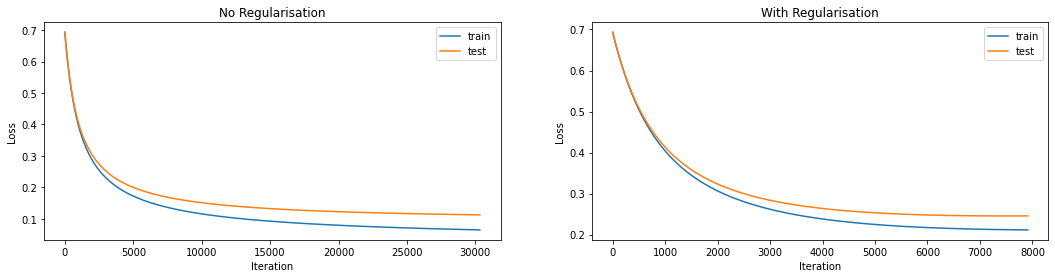

In [50]:
logistic_regression = LogisticRegression(number_of_features=len(features_to_use_3))
trained_model, loss_vals_final_no_reg = logistic_regression.fit(train_data_rep3, train_label, test_data_rep3, test_label, verbose=False, lr=5e-4, reg_term=0.0)

print("Capacity of the feature set 3 without regularization model")
training_accuracy = logistic_regression.predict(train_data_rep3, train_label)
test_accuracy = logistic_regression.predict(test_data_rep3, test_label)
print(f"Training accuracy is {training_accuracy}, Test accuracy is {test_accuracy}")

logistic_regression = LogisticRegression(number_of_features=len(features_to_use_3))
trained_model, loss_vals_final_with_reg = logistic_regression.fit(train_data_rep3, train_label, test_data_rep3, test_label, verbose=False, lr=5e-4, reg_term=0.1)

print("Capacity of the feature set 3 with regularization model")
training_accuracy = logistic_regression.predict(train_data_rep3, train_label)
test_accuracy = logistic_regression.predict(test_data_rep3, test_label)
print(f"Training accuracy is {training_accuracy}, Test accuracy is {test_accuracy}")


fig = plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(loss_vals_final_no_reg['train_loss'], label='train')
ax1.plot(loss_vals_final_no_reg['test_loss'], label='test')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.title.set_text("No Regularisation")
ax1.legend(loc='upper right')

ax2.plot(loss_vals_final_with_reg['train_loss'], label='train')
ax2.plot(loss_vals_final_with_reg['test_loss'], label='test')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss")
ax2.title.set_text("With Regularisation")
ax2.legend(loc='upper right')

plt.show()